In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

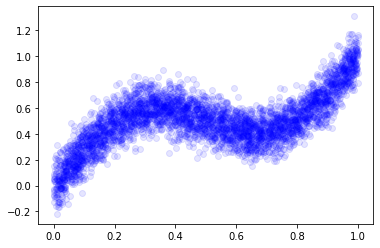

In [27]:
def create_toydata(n):

    x = np.random.uniform(0., 1., size=(n, 1)).astype(np.float32)
    y = x + 0.3 * np.sin(2 * np.pi * x) + \
        np.random.normal(0, 0.1, size=(n, 1)).astype(np.float32)
    x_test = np.linspace(0, 1, n).reshape(-1, 1)

    return x, y, x_test

X, Y, X_test = create_toydata(4000)
plt.plot(X, Y, "bo", alpha=0.1)
plt.show()

In [15]:
tf.__version__

'2.4.0'

In [16]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
tf.executing_eagerly()

True

In [18]:
"""Get the Mixture density model"""
l = 1 # the number of input features
k = 26 # the number of mixtures

def get_model(l, k):

    input = tf.keras.Input(shape=(l,))
    layer = tf.keras.layers.Dense(50, activation="tanh", name="baselayer")(input)

    mu = tf.keras.layers.Dense((l * k), activation=None, name="mean_layer")(layer)
    # mu (- Real numbers
    var_layer = tf.keras.layers.Dense(k, activation=None, name="variance_layer")(layer)
    var = tf.keras.layers.Lambda(lambda x : tf.math.exp(x), output_shape=(k,), name="variance")(var_layer)

    pi = tf.keras.layers.Dense(k, activation="softmax", name="pi_layer")(layer)
    model = tf.keras.Model(input, [mu, var, pi])
    return model

In [19]:
optimizer = tf.keras.optimizers.Adam()
model = get_model(l, k)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
baselayer (Dense)               (None, 50)           100         input_3[0][0]                    
__________________________________________________________________________________________________
variance_layer (Dense)          (None, 26)           1326        baselayer[0][0]                  
__________________________________________________________________________________________________
mean_layer (Dense)              (None, 26)           1326        baselayer[0][0]                  
____________________________________________________________________________________________

In [20]:
def calc_pdf(mu, var, y):
    """Calculate the gaussian pdf"""
    Z = tf.subtract(y, mu) ** 2
    pdf = (1 / tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1 / (2 * var)) * Z)

    return pdf

def mdn_loss(y_true, mu, var, pi):
    """The mixture density loss function"""
    out = calc_pdf(mu, var, y_true)

    out = tf.multiply(pi, out)
    out = tf.reduce_sum(out, axis=1, keepdims=True)

    out = -tf.math.log(out + 1e-6)

    return tf.reduce_mean(out)


In [21]:
"""The train step"""
train_data = tf.data.Dataset.from_tensor_slices((Y, X)).shuffle(len(Y)).batch(len(Y))
@tf.function
def train_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        mu_, var_, pi_ = model(x_batch, training=True)
        loss = mdn_loss(y_batch, mu_, var_, pi_)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss



In [22]:
import time

losses = []
epochs = 6000

"""The training loop"""
for epoch in range(epochs):

    start = time.time()
    for x_batch, y_batch in train_data:
        loss = train_step(model, optimizer, x_batch, y_batch)
        losses.append(loss)
    if epoch % 600 == 0:

        print("Epoch : {}, loss : {} ...... time taken : {}".format(epoch+1, losses[-1], time.time()-start))




Epoch : 1, loss : 1.1051164865493774 ...... time taken : 1.062974452972412
Epoch : 601, loss : -0.5431663990020752 ...... time taken : 0.04390978813171387
Epoch : 1201, loss : -0.639700710773468 ...... time taken : 0.030895233154296875
Epoch : 1801, loss : -0.6643941402435303 ...... time taken : 0.02892613410949707
Epoch : 2401, loss : -0.6777462959289551 ...... time taken : 0.030373334884643555
Epoch : 3001, loss : -0.681884765625 ...... time taken : 0.03140687942504883
Epoch : 3601, loss : -0.6848645210266113 ...... time taken : 0.031114578247070312
Epoch : 4201, loss : -0.6858975887298584 ...... time taken : 0.03358793258666992
Epoch : 4801, loss : -0.6855448484420776 ...... time taken : 0.031813859939575195
Epoch : 5401, loss : -0.6859221458435059 ...... time taken : 0.036416053771972656


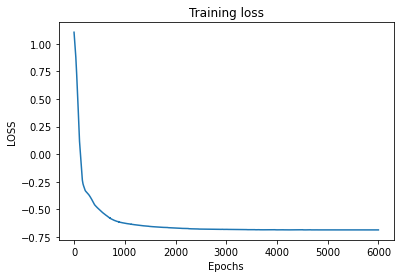

In [23]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Epochs")
plt.ylabel("LOSS")
plt.title("Training loss")
plt.show()

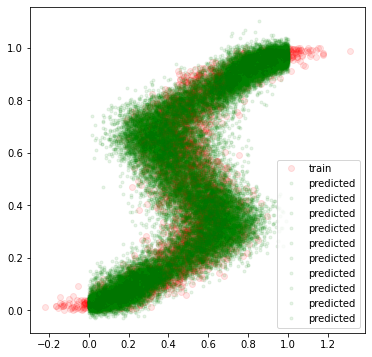

In [29]:
mu_vals, var_vals, pi_vals = model.predict(X_test)

def sample_from_dist(mu_vals, var_vals, pi_vals, n_samples):

    n, k = pi_vals.shape
    out = np.zeros((n, n_samples, l))
    for i in range(n):
        for j in range(n_samples):
            idx = np.random.choice(range(k), p = pi_vals[i])

            for li in range(l):

                out[i, j, li] = np.random.normal(mu_vals[i, idx * (li+l)], np.sqrt(var_vals[i, idx]))

    return out

samples = sample_from_dist(mu_vals, var_vals, pi_vals, n_samples=10)
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(Y, X, 'ro', label='train', alpha=0.1)
for i in range(samples.shape[1]):
     plt.plot(X_test, samples[:, i], 'g.', alpha=0.09, label='predicted')

plt.legend()
plt.show()


